## AutoEncoders on PointClouds - ORIONG Code

In [4]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.point_net_ae import Configuration as PN_Conf

from general_tools.in_out.basics import create_dir, delete_files_in_directory
from geo_tool import Point_Cloud

from general_tools.in_out.basics import files_in_subdirs

In [60]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

data_path = '/orions4-zfs/projects/lins2/Panos_Space/DATA/ShapeNetPointClouds/from_manifold_meshes/1024/03001627/'
train_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/'

experiment_name = 'virt-scan-chairs-only-ae'
train_dir = osp.join(train_dir, experiment_name)

create_dir(train_dir)
delete_files_in_directory(train_dir)

In [4]:
file_names = pio.load_filenames_of_input_data(data_path)
full_pclouds, full_model_names = pio.load_crude_point_clouds(file_names=file_names, n_threads=11)


# train_data_, val_data_, test_data_ = pio.train_validate_test_split([pclouds_original, model_names_original],
#                                                                    train_perc=0.8,
#                                                                    validate_perc=0.1,
#                                                                    test_perc=0.1,
#                                                                    seed=seed)

# train_data = PointCloudDataSet(train_data_[0], labels=train_data_[1])
# val_data = PointCloudDataSet(val_data_[0], labels=val_data_[1])
# test_data = PointCloudDataSet(test_data_[0], labels=test_data_[1])

6778 files containing  point clouds were found.


In [125]:
virtual_scan_data = '/orions4-zfs/projects/lins2/Panos_Space/DATA/From_Mathhias/shapenet_dim32_sdf_pc/03001627/'
noisy_pcloud_files = []
vscan_search_pattern = 
for file_name in files_in_subdirs(virtual_scan_data, vscan_search_pattern + '$'):
    noisy_pcloud_files.append(file_name)    

print '%d files containing noisy point clouds were found.' % (len(noisy_pcloud_files), )

6000 files containing noisy point clouds were found.


In [137]:
start = time.time()
noisy_pclouds, noisy_model_names = pio.load_crude_point_clouds(file_names=noisy_pcloud_files, 
                                                               n_threads=11, 
                                                               loader=_load_virtual_scan_pcloud_and_model_id)

print time.time() - start

# print np.mean([_load_virtual_scan_pcloud_and_model_id(i) for i in noisy_pcloud_files])

1.6499941349


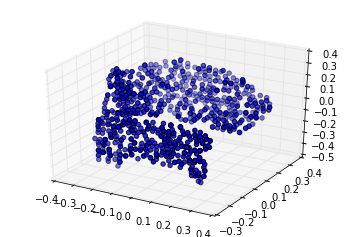

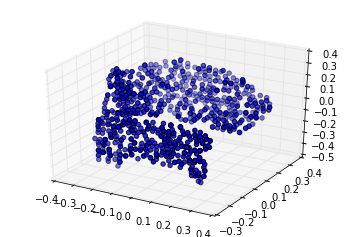

In [146]:



# Point_Cloud(points=noisy_pclouds[12]).plot()

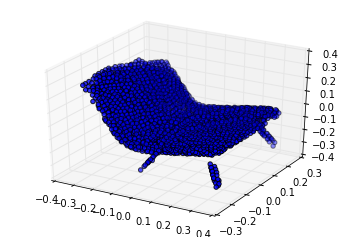

3943


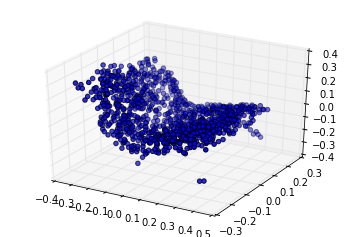

1024


In [42]:
# pclouds_orig_sub = pclouds_original[mapping]
# noisy_pclouds_processed = noisy_pclouds.copy()
# for i, pc in enumerate(noisy_pclouds):
#     pc_ = Point_Cloud(points=pc)
#     pc_.lex_sort()
#     pc_.center_in_unit_sphere()
#     pc.permute_points([0, 2, 1])
#     noisy_pclouds_processed[i] = pc_.points


# def reset_graph():
#     if 'sess' in globals() and sess:
#         sess.close()
#     tf.reset_default_graph()


# conf = PN_Conf(n_input = [1024, 3],
#                training_epochs = 100,
#                batch_size = 40,
#                loss = 'l2',
#                train_dir = train_dir,
#                loss_display_step = 1,               
#                saver_step = 5,
#                learning_rate = 0.0002,
#                debug = True               
#               )

# reset_graph()

# ae = PointNetAutoEncoder(experiment_name, conf)

# if conf.debug:
#     ae.train_names = set(train_data_[1])

# ae.train(train_data, conf)

In [15]:
top_directory = '/orions4-zfs/projects/lins2/Lin_Space/DATA/ImcompleteScanningPointClouds/03001627/'
noisy_pcloud_files = []
search_pattern = '0_noisy00000.txt'
for file_name in files_in_subdirs(top_directory, search_pattern + '$'):
    noisy_pcloud_files.append(file_name)    

print '%d files containing noisy point clouds were found.' % (len(noisy_pcloud_files), )


from geo_tool.in_out.soup import load_crude_point_cloud

def _load_kinect_pcloud_and_model_id(f_name):
        return [load_crude_point_cloud(f_name), f_name.split('/')[-2]]

noisy_pcloud_files = noisy_pcloud_files[:100]
noisy_pclouds, noisy_model_names = pio.load_crude_point_clouds(file_names=noisy_pcloud_files, 
                                                               n_threads=11, 
                                                               loader=_load_kinect_pcloud_and_model_id)




3738 files containing noisy point clouds were found.


In [17]:
pclouds_orig_sub = pclouds_original[mapping]
noisy_pclouds_processed = noisy_pclouds.copy()

for i, pc in enumerate(noisy_pclouds):
    pc_ = Point_Cloud(points=pc)
    pc_.lex_sort()
    pc_.center_in_unit_sphere()
    pc.permute_points([0,2,1])
    noisy_pclouds_processed[i] = pc_.points

In [10]:
train_data_, _, test_data_ = pio.train_validate_test_split([pclouds_orig_sub, 
                                                            noisy_pclouds_processed, 
                                                            noisy_model_names],
                                                            train_perc=0.9,
                                                            validate_perc=0.0,
                                                            test_perc=0.1,
                                                            seed=seed)

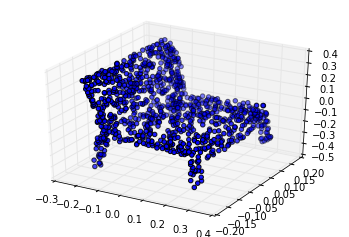

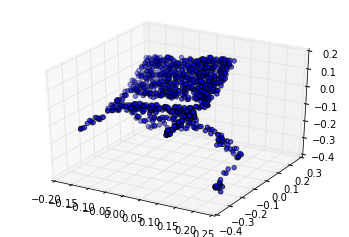

In [21]:
import tf_lab.models.point_net_based_AE as pnAE

def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()


conf = PN_Conf(n_input = [1024, 3],
               training_epochs = 1000,
               batch_size = 40,
               loss = 'Chamfer',
               train_dir = train_dir,
               loss_display_step = 1,
               saver_step = 5,
               learning_rate = 0.0002,
               debug = False,
               saver_max_to_keep = 200,
               gauss_augment = {'mu': 0, 'sigma': 0.02},
               encoder = pnAE.encoder,
               decoder = pnAE.decoder,
               spatial_trans = True,               
               denoising = True
              )

reset_graph()

ae = PointNetAutoEncoder(experiment_name, conf)

# if conf.debug:
#     ae.train_names = set(train_data_[1])

ae.train(train_data, conf)


('Epoch:', '0001', 'training time (minutes)=', '1.7673', 'loss=', '0.013396031')
('Epoch:', '0002', 'training time (minutes)=', '0.1342', 'loss=', '0.003718698')
('Epoch:', '0003', 'training time (minutes)=', '0.1344', 'loss=', '0.003526837')
('Epoch:', '0004', 'training time (minutes)=', '0.1355', 'loss=', '0.003487331')
('Epoch:', '0005', 'training time (minutes)=', '0.1345', 'loss=', '0.003412327')
('Epoch:', '0006', 'training time (minutes)=', '0.1399', 'loss=', '0.003375816')
('Epoch:', '0007', 'training time (minutes)=', '0.1386', 'loss=', '0.003243344')
('Epoch:', '0008', 'training time (minutes)=', '0.1373', 'loss=', '0.003096079')
('Epoch:', '0009', 'training time (minutes)=', '0.1349', 'loss=', '0.002995273')
('Epoch:', '0010', 'training time (minutes)=', '0.1351', 'loss=', '0.002971443')
('Epoch:', '0011', 'training time (minutes)=', '0.1357', 'loss=', '0.002936782')
('Epoch:', '0012', 'training time (minutes)=', '0.1366', 'loss=', '0.002912542')
('Epoch:', '0013', 'training

[(1, 0.013396031217693928, 106.0357711315155),
 (2, 0.0037186980979251011, 8.051426887512207),
 (3, 0.0035268372018998932, 8.06477403640747),
 (4, 0.0034873313492252713, 8.129625082015991),
 (5, 0.0034123265206636418, 8.067061185836792),
 (6, 0.0033758155851890998, 8.392357110977173),
 (7, 0.00324334443125519, 8.314802885055542),
 (8, 0.0030960794205644299, 8.238590002059937),
 (9, 0.0029952726465472508, 8.095373153686523),
 (10, 0.0029714432450765301, 8.10575008392334),
 (11, 0.0029367822349914128, 8.141109943389893),
 (12, 0.0029125419428705107, 8.197021961212158),
 (13, 0.002879699597889114, 8.14986801147461),
 (14, 0.0028770153848676101, 8.07892394065857),
 (15, 0.0028573937874863901, 8.232253074645996),
 (16, 0.0028380475788643317, 8.269779920578003),
 (17, 0.0028210848658567385, 8.141254186630249),
 (18, 0.0028125343655812599, 8.256824970245361),
 (19, 0.0028107863645778879, 8.467581987380981),
 (20, 0.002827287978670072, 8.290215015411377),
 (21, 0.0027871585140625634, 8.1543059

In [51]:
# # gen_error, best_epoch, stats = generalization_error(ae, train_data, test_data, None, conf)

# # _, loss_tes, _ = ae.evaluate(test_data, conf)
# # _, loss_val, _ = ae.evaluate(val_data, conf)

# # if loss_val < loss_tes:
# #     print 'val winner'
# # else:
# #     print 'test winner'

In [105]:
from tf_lab.autopredictors.evaluate.basics import read_saved_epochs, generalization_error
stats = eval_model(ae, conf, [train_data, test_data], range(10, 1000, 50))

Model restored in epoch 10.
Model restored in epoch 60.
Model restored in epoch 110.
Model restored in epoch 160.
Model restored in epoch 210.
Model restored in epoch 260.
Model restored in epoch 310.
Model restored in epoch 360.
Model restored in epoch 410.
Model restored in epoch 460.
Model restored in epoch 510.
Model restored in epoch 560.
Model restored in epoch 610.
Model restored in epoch 660.
Model restored in epoch 710.
Model restored in epoch 760.
Model restored in epoch 810.
Model restored in epoch 860.
Model restored in epoch 910.
Model restored in epoch 960.


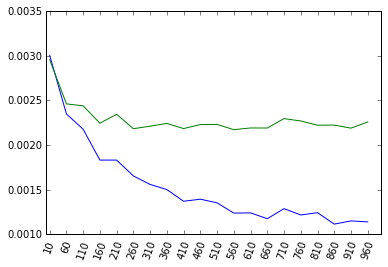

In [106]:
fig, ax = plt.subplots();
x = range(10, 1000, 50);
plt.plot(x, stats[:,1]);
plt.plot(x, stats[:,2]);
plt.xticks(rotation=70);
ax.set_xticks(x);

# np.set_printoptions(suppress=True)
# for s in stats[:,1]:
#     print '%.9f' % (s, )

In [143]:
# from tf_lab.autopredictors.plotting.basics import plot_reconstructions_at_epoch
# plot_reconstructions_at_epoch(110, ae, test_data, conf, conf.train_dir, max_plot=20)

In [146]:
ae.restore_model(conf.train_dir, 110)
ae.evaluate(test_data, conf)
reconstructed, _, original = ae.evaluate(test_data, conf)
plot_original_pclouds_vs_reconstructed(original, reconstructed, conf.train_dir, max_plot=20)


Model restored in epoch 110.
